In [1]:
#new plotting code
#old samples (50,000)

# Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import lalsimulation as lal
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import keras
import keras_metrics as km
import keras
import keras_metrics as km
from keras import metrics

2023-09-12 12:28:18.114817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
gamma0 = np.loadtxt("eos_polytrope_gamma_0-50000.dat.txt", dtype=float)
gamma1 = np.loadtxt("eos_polytrope_gamma_1-50000.dat.txt", dtype=float)
gamma2 = np.loadtxt("eos_polytrope_gamma_2-50000.dat.txt", dtype=float)
l1 = np.loadtxt('lambda_1-50000.dat.txt', dtype=float)
l2 = np.loadtxt('lambda_2-50000.dat.txt', dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1-50000.dat.txt", dtype=float)
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2-50000.dat.txt", dtype=float)
m1 = np.loadtxt("mass_1_source-50000.dat.txt", dtype=float)
m2 = np.loadtxt("mass_2_source-50000.dat.txt", dtype=float)

logp1_s = logp1_cgs - 1
logp2_s = logp2_cgs - 1

In [4]:
len(m2)

50000

# Functions

In [5]:
#formatting array & processing outputs

def format_output(data):
    gamma0 = data.pop('gamma0')
    gamma0 = np.array(gamma0)
    gamma1 = data.pop('gamma1')
    gamma1 = np.array(gamma1)
    gamma2 = data.pop('gamma2')
    gamma2 = np.array(gamma2)
    logp1_si = data.pop('logp1_si')
    logp1_si = np.array(logp1_si)
    logp2_si = data.pop('logp2_si')
    logp2_si = np.array(logp2_si)
    return gamma0, gamma1, gamma2, logp1_si, logp2_si



In [6]:
#normalize and save the new array, and the max

def minmax(inputarray):
    
    absinput = np.abs(inputarray)
    gmax = absinput.max()
    newarray = inputarray / gmax
                
    return newarray, gmax


In [7]:
#return inputs back to original values in order to plot EOS

def unnorm(predictionsarray, gam0max, gam1max, gam2max, logp1max, logp2max):
    
    for i in range (len(predictionsarray)):
        new_gamma0_array = predictionsarray[0] * gam0max
        new_gamma1_array = predictionsarray[1] * gam1max
        new_gamma2_array = predictionsarray[2] * gam2max
        new_logp1_array = predictionsarray[3] *  logp1max
        new_logp2_array = predictionsarray[4] *  logp2max
    
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, new_logp1_array, new_logp2_array), axis=1)

    return new_array

# MLA

In [8]:
# not normalized

#l1_dat = (l1)
#l2_dat = (l2)
#m1_dat = (m1)
#m2_dat = (m2)

#sd_gamma0 = (gamma0)
#sd_gamma1 = (gamma1)
#sd_gamma2 = (gamma2)
#logp1_si  = (logp1_s)
#logp2_si  = (logp2_s)

In [11]:
#normalizing inputs and outputs

l1_dat, l1max = minmax(l1)
l2_dat, l2max = minmax(l2)
m1_dat, m1max = minmax(m1)
m2_dat, m2max = minmax(m2)


sd_gamma0, gam0max = minmax(gamma0)
sd_gamma1, gam1max = minmax(gamma1)
sd_gamma2, gam2max = minmax(gamma2)
logp1_si, logp1max = minmax(logp1_s)
logp2_si, logp2max = minmax(logp2_s)


In [12]:
#create an empty array 8 x length(m1_dat]) for vals
array_size =  np.array([[0] * 9 ] * len(sd_gamma0))
array_size = array_size.astype('float64')
combined_array = np.zeros_like(array_size)
print(combined_array.dtype)
print(combined_array.shape)

float64
(50000, 9)


In [13]:
#reformat data files into this new array
for i in range(0,len(m1_dat)-1):
    combined_array[i][0] = m1_dat[i]
    combined_array[i][1] = m2_dat[i]
    combined_array[i][2] = l1_dat[i]
    combined_array[i][3] = l2_dat[i]
    combined_array[i][4] = sd_gamma0[i]
    combined_array[i][5] = sd_gamma1[i]
    combined_array[i][6] = sd_gamma2[i]
    combined_array[i][7] = logp1_si[i]
    combined_array[i][8] = logp2_si[i]
    

In [14]:
data = pd.DataFrame(combined_array)
data.columns = ['m1','m2', 'l1', 'l2','gamma0', 'gamma1', 'gamma2', 'logp1_si', 'logp2_si']
print(data)

             m1        m2            l1            l2    gamma0    gamma1  \
0      0.410692  0.231189  3.541348e-16  3.541348e-16  0.549963  0.832750   
1      0.162457  0.120106  3.114506e-13  3.114506e-13  0.719085  0.796395   
2      0.468558  0.399788  1.224292e-15  1.224292e-15  0.704071  0.990515   
3      0.140382  0.089042  3.537702e-13  3.537702e-13  0.583426  0.229973   
4      0.646790  0.605635  3.733538e-16  3.733538e-16  0.850528  0.664299   
...         ...       ...           ...           ...       ...       ...   
49995  0.263401  0.213107  4.704569e-14  4.704569e-14  0.758352  0.954622   
49996  0.108458  0.103766  5.776775e-13  5.776775e-13  0.472402  0.555586   
49997  0.296176  0.225375  2.316470e-14  2.316470e-14  0.658760  0.826133   
49998  0.213106  0.164141  1.454456e-13  1.454456e-13  0.919760  0.761335   
49999  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000   

         gamma2  logp1_si  logp2_si  
0      0.283657  0.954784  0.965722  

In [18]:
#split data into train and test

data = data.sample(frac=1).reset_index(drop=True)

train, test = train_test_split(data, test_size=0.2)

print(train)

train_stats = train.describe()

#get gamma as the outputs and format them as np arrays.

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('logp1_si')
train_stats.pop('logp2_si')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

             m1        m2            l1            l2    gamma0    gamma1  \
22466  0.624679  0.589331  1.492659e-16  1.492659e-16  0.623262  0.799395   
36472  0.261603  0.129722  1.683839e-14  1.683839e-14  0.601723  0.245229   
48620  0.228905  0.217948  5.468469e-15  5.468469e-15  0.446343  0.568373   
1985   0.289246  0.182840  1.529995e-14  1.529995e-14  0.773855  0.634532   
3865   0.400577  0.092211  2.779452e-15  2.779452e-15  0.683295  0.692732   
...         ...       ...           ...           ...       ...       ...   
14460  0.734006  0.696809  2.426875e-16  2.426875e-16  0.780507  0.979876   
18839  0.355137  0.272437  7.467160e-15  7.467160e-15  0.733519  0.214471   
41055  0.200472  0.203343  1.068682e-13  1.068682e-13  0.689355  0.376907   
2031   0.259494  0.239750  4.518242e-15  4.518242e-15  0.484244  0.730906   
11510  0.609733  0.493234  8.206494e-17  8.206494e-17  0.595020  0.854835   

         gamma2  logp1_si  logp2_si  
22466  0.409422  0.908319  0.989982  

In [19]:
norm_train_X = train
norm_test_X = test

In [20]:

input_layer = Input(shape=(len(train .columns),))

first_dense = Dense(units='128', activation='tanh')(input_layer)
second_dense = Dense(units='128', activation='tanh')(first_dense)
third_dense = Dense(units='128', activation='tanh')(second_dense)
fourth_dense = Dense(units='128', activation='tanh')(third_dense)
fifth_dense = Dense(units='128', activation='tanh')(fourth_dense)
sixth_dense = Dense(units='128', activation='tanh')(fifth_dense)
seventh_dense = Dense(units='128', activation='tanh')(sixth_dense)
eight_dense = Dense(units='128', activation='tanh')(seventh_dense)
ninth_dense = Dense(units='128', activation='tanh')(eight_dense)
    
tenth_dense = Dense(units='128', activation='tanh')(ninth_dense)
eleventh_dense = Dense(units='128', activation='tanh')(tenth_dense)
twelth_dense = Dense(units='128', activation='tanh')(eleventh_dense)
thirteenth_dense = Dense(units='128', activation='tanh')(twelth_dense)
fourteenth_dense = Dense(units='128', activation='tanh')(thirteenth_dense)
fifteenth_dense = Dense(units='128', activation='tanh')(fourteenth_dense)
sixteenth_dense = Dense(units='128', activation='tanh')(fifteenth_dense)
seventeenth_dense = Dense(units='128', activation='tanh')(sixteenth_dense)
eighteenth_dense = Dense(units='128', activation='tanh')(seventeenth_dense)
nineteenth_dense = Dense(units='128', activation='tanh')(eighteenth_dense)
    
twentieth_dense = Dense(units='128', activation='tanh')(nineteenth_dense)
tf_dense = Dense(units='128', activation='tanh')(twentieth_dense)
ts_dense = Dense(units='128', activation='tanh')(tf_dense)
tt_dense = Dense(units='128', activation='tanh')(ts_dense)
tfo_dense = Dense(units='128', activation='tanh')(tt_dense)
tfi_dense = Dense(units='128', activation='tanh')(tfo_dense)
ts_dense = Dense(units='128', activation='tanh')(tfi_dense)
tse_dense = Dense(units='128', activation='tanh')(ts_dense)
te_dense = Dense(units='128', activation='tanh')(tse_dense)
tn_dense = Dense(units='128', activation='tanh')(te_dense)


gamma0_output = Dense(units='1', activation='tanh', name='gamma0_output')(tn_dense)
thf_dense = Dense(units='64', activation='tanh')(tn_dense)

ths_dense = Dense(units='128', activation='tanh')(thf_dense)
tht_dense = Dense(units='128', activation='tanh')(ths_dense)
thfo_dense = Dense(units='128', activation='tanh')(tht_dense)
thfi_dense = Dense(units='128', activation='tanh')(thfo_dense)
ths_dense = Dense(units='128', activation='tanh')(thfi_dense)
thse_dense = Dense(units='128', activation='tanh')(ths_dense)
the_dense = Dense(units='128', activation='tanh')(thse_dense)
thn_dense = Dense(units='128', activation='tanh')(the_dense)

gamma1_output = Dense(units='1', activation='tanh', name='gamma1_output')(thn_dense)
fo_dense = Dense(units='32',activation='tanh')(thn_dense)

fof_dense = Dense(units='128', activation='tanh')(fo_dense)
fos_dense = Dense(units='128', activation='tanh')(fof_dense)
fot_dense = Dense(units='128', activation='tanh')(fos_dense)
fofo_dense = Dense(units='128', activation='tanh')(fot_dense)
fofi_dense = Dense(units='128', activation='tanh')(fofo_dense)

gamma2_output = Dense(units='1', activation='tanh', name='gamma2_output')(fofi_dense)
fos_dense = Dense(units='16',activation='tanh')(fofi_dense)

fose_dense = Dense(units='128', activation='tanh')(fos_dense)
foe_dense = Dense(units='128', activation='tanh')(fose_dense)
fon_dense = Dense(units='128', activation='tanh')(foe_dense)
fif_dense = Dense(units='128', activation='tanh')(fon_dense)

logp1_si_output = Dense(units='1', activation='tanh', name='logp1_si_output')(fon_dense)

fiff_dense = Dense(units='128', activation='tanh')(fon_dense)
fifs_dense = Dense(units='128', activation='tanh')(fiff_dense)
fift_dense = Dense(units='128', activation='tanh')(fifs_dense)
fiff_dense = Dense(units='128', activation='tanh')(fift_dense)
fiffi_dense = Dense(units='128', activation='tanh')(fiff_dense)
fifs_dense = Dense(units='128', activation='tanh')(fiffi_dense)

logp2_si_output = Dense(units='1', activation='tanh', name='logp2_si_output')(fifs_dense)


model = Model(inputs=input_layer, outputs=[gamma0_output, gamma1_output, gamma2_output, logp1_si_output, logp2_si_output])

print(model.summary())

2023-09-12 12:31:48.941365: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          640         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          16512       ['dense_1[0][0]']                
                                                                                              

 dense_39 (Dense)               (None, 128)          4224        ['dense_38[0][0]']               
                                                                                                  
 dense_40 (Dense)               (None, 128)          16512       ['dense_39[0][0]']               
                                                                                                  
 dense_41 (Dense)               (None, 128)          16512       ['dense_40[0][0]']               
                                                                                                  
 dense_42 (Dense)               (None, 128)          16512       ['dense_41[0][0]']               
                                                                                                  
 dense_43 (Dense)               (None, 128)          16512       ['dense_42[0][0]']               
                                                                                                  
 dense_44 

In [16]:
#plot_model(model, to_file='DynamicPolytropeMLA.png', show_shapes=True, show_layer_names=True)

In [21]:
#specify the optimizer as stochastic gradient descent and will mention the learning rate as 0.001
#compile the model with loss functions for both outputs
from keras import metrics

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma0_output': 'mse', 'gamma1_output': 'mse', 'gamma2_output': 'mse', 'logp1_si_output': 'mse', 'logp2_si_output': 'mse'},
              metrics={
                       'gamma0_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma1_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma2_output': tf.keras.metrics.MeanSquaredError() ,
                       'logp1_si_output': tf.keras.metrics.MeanSquaredError(),
                       'logp2_si_output': tf.keras.metrics.MeanSquaredError()
                      })

endmetric = "mean_squared_error"

In [22]:
#train the model for a number of epochs

numepochs = 10
    
history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=50,mode='auto')])


Epoch 1/10
3200/3200 [==============================] - 52s 15ms/step - loss: 0.0926 - gamma0_output_loss: 0.0331 - gamma1_output_loss: 0.0474 - gamma2_output_loss: 0.0098 - logp1_si_output_loss: 0.0013 - logp2_si_output_loss: 9.3975e-04 - gamma0_output_mean_squared_error: 0.0331 - gamma1_output_mean_squared_error: 0.0474 - gamma2_output_mean_squared_error: 0.0098 - logp1_si_output_mean_squared_error: 0.0013 - logp2_si_output_mean_squared_error: 9.3975e-04 - val_loss: 0.0887 - val_gamma0_output_loss: 0.0319 - val_gamma1_output_loss: 0.0453 - val_gamma2_output_loss: 0.0100 - val_logp1_si_output_loss: 9.2972e-04 - val_logp2_si_output_loss: 5.4738e-04 - val_gamma0_output_mean_squared_error: 0.0319 - val_gamma1_output_mean_squared_error: 0.0453 - val_gamma2_output_mean_squared_error: 0.0100 - val_logp1_si_output_mean_squared_error: 9.2972e-04 - val_logp2_si_output_mean_squared_error: 5.4738e-04
Epoch 2/10
3200/3200 [==============================] - 45s 14ms/step - loss: 0.0888 - gamma0_ou

Epoch 10/10
3200/3200 [==============================] - 45s 14ms/step - loss: 0.0875 - gamma0_output_loss: 0.0316 - gamma1_output_loss: 0.0458 - gamma2_output_loss: 0.0089 - logp1_si_output_loss: 7.0656e-04 - logp2_si_output_loss: 4.4254e-04 - gamma0_output_mean_squared_error: 0.0316 - gamma1_output_mean_squared_error: 0.0458 - gamma2_output_mean_squared_error: 0.0089 - logp1_si_output_mean_squared_error: 7.0656e-04 - logp2_si_output_mean_squared_error: 4.4254e-04 - val_loss: 0.0876 - val_gamma0_output_loss: 0.0318 - val_gamma1_output_loss: 0.0453 - val_gamma2_output_loss: 0.0091 - val_logp1_si_output_loss: 8.0085e-04 - val_logp2_si_output_loss: 5.4492e-04 - val_gamma0_output_mean_squared_error: 0.0318 - val_gamma1_output_mean_squared_error: 0.0453 - val_gamma2_output_mean_squared_error: 0.0091 - val_logp1_si_output_mean_squared_error: 8.0085e-04 - val_logp2_si_output_mean_squared_error: 5.4492e-04


In [23]:
loss, gamma0_loss, gamma0_accuracy, gamma1_loss, gamma1_accuracy, gamma2_loss, gamma2_accuracy, logp1_si_loss, logp1_si_accuracy, logp2_si_loss, logp2_si_accuracy = model.evaluate(x=norm_test_X.to_numpy(), y=test_Y)


313/313 [==============================] - 2s 6ms/step - loss: 0.0888 - gamma0_output_loss: 0.0319 - gamma1_output_loss: 0.0469 - gamma2_output_loss: 0.0089 - logp1_si_output_loss: 6.9532e-04 - logp2_si_output_loss: 4.2564e-04 - gamma0_output_mean_squared_error: 0.0319 - gamma1_output_mean_squared_error: 0.0469 - gamma2_output_mean_squared_error: 0.0089 - logp1_si_output_mean_squared_error: 6.9532e-04 - logp2_si_output_mean_squared_error: 4.2564e-04


In [24]:
new_predictions = model.predict(norm_train_X.to_numpy())
predictions = unnorm(new_predictions, gam0max, gam1max, gam2max, logp1max, logp2max)

1250/1250 [==============================] - 6s 5ms/step


In [24]:
len(predictions)

40000

# Plot one EOS

In [37]:
fgam0 = float(predictions[0][0])
fgam1 = float(predictions[0][1])
fgam2 = float(predictions[0][2])
flogp1 = float(predictions[0][3])
flogp2 = float(predictions[0][4])

In [38]:
oneEOS = lal.SimNeutronStarEOS3PieceDynamicPolytrope(fgam0, flogp1, fgam1, flogp2, fgam2)

In [39]:
act_hmin = 0.01
act_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(oneEOS)

act_loghmin = np.log10(act_hmin)
act_loghmax = np.log10(act_hmax)

act_h_array = np.linspace(act_loghmin,act_loghmax,1000)

act_density = []
act_pressure = []

for h in act_h_array:
    act_density.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(10**h,oneEOS))
    act_pressure.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(10**h,oneEOS))
    
    
act_density = np.array(act_density)
act_pressure = np.array(act_pressure)

#cgs units
act_density_cgs = act_density * 1e-3
act_pressure_cgs = act_pressure * 10

act_logdensity = np.log10(act_density_cgs)
act_logpressure = np.log10(act_pressure_cgs)

Text(0, 0.5, 'pressure')

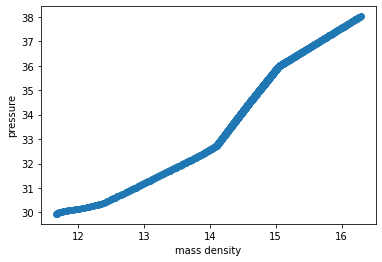

In [40]:
plt.plot(act_logdensity,act_logpressure,marker = 'o')
plt.xlabel("mass density")
plt.ylabel("pressure")
#plt.xlim([14,15.4])
#plt.ylim([32,37])

# EOS


In [51]:
length = len(predictions)

Progress : 0 / 40000, 0.00%
Progress : 10 / 40000, 0.03%
Progress : 20 / 40000, 0.05%
Progress : 30 / 40000, 0.07%
Progress : 40 / 40000, 0.10%
Progress : 50 / 40000, 0.12%
Progress : 60 / 40000, 0.15%
Progress : 70 / 40000, 0.18%
Progress : 80 / 40000, 0.20%
Progress : 90 / 40000, 0.22%
Progress : 100 / 40000, 0.25%
Progress : 110 / 40000, 0.27%
Progress : 120 / 40000, 0.30%
Progress : 130 / 40000, 0.33%
Progress : 140 / 40000, 0.35%
Progress : 150 / 40000, 0.38%
Progress : 160 / 40000, 0.40%
Progress : 170 / 40000, 0.43%
Progress : 180 / 40000, 0.45%
Progress : 190 / 40000, 0.47%
Progress : 200 / 40000, 0.50%
Progress : 210 / 40000, 0.53%
Progress : 220 / 40000, 0.55%
Progress : 230 / 40000, 0.57%
Progress : 240 / 40000, 0.60%
Progress : 250 / 40000, 0.62%
Progress : 260 / 40000, 0.65%
Progress : 270 / 40000, 0.68%
Progress : 280 / 40000, 0.70%
Progress : 290 / 40000, 0.73%
Progress : 300 / 40000, 0.75%
Progress : 310 / 40000, 0.78%
Progress : 320 / 40000, 0.80%
Progress : 330 / 4000

Progress : 2680 / 40000, 6.70%
Progress : 2690 / 40000, 6.73%
Progress : 2700 / 40000, 6.75%
Progress : 2710 / 40000, 6.78%
Progress : 2720 / 40000, 6.80%
Progress : 2730 / 40000, 6.83%
Progress : 2740 / 40000, 6.85%
Progress : 2750 / 40000, 6.88%
Progress : 2760 / 40000, 6.90%
Progress : 2770 / 40000, 6.93%
Progress : 2780 / 40000, 6.95%
Progress : 2790 / 40000, 6.98%
Progress : 2800 / 40000, 7.00%
Progress : 2810 / 40000, 7.03%
Progress : 2820 / 40000, 7.05%
Progress : 2830 / 40000, 7.07%
Progress : 2840 / 40000, 7.10%
Progress : 2850 / 40000, 7.12%
Progress : 2860 / 40000, 7.15%
Progress : 2870 / 40000, 7.17%
Progress : 2880 / 40000, 7.20%
Progress : 2890 / 40000, 7.22%
Progress : 2900 / 40000, 7.25%
Progress : 2910 / 40000, 7.27%
Progress : 2920 / 40000, 7.30%
Progress : 2930 / 40000, 7.32%
Progress : 2940 / 40000, 7.35%
Progress : 2950 / 40000, 7.38%
Progress : 2960 / 40000, 7.40%
Progress : 2970 / 40000, 7.42%
Progress : 2980 / 40000, 7.45%
Progress : 2990 / 40000, 7.47%
Progress

Progress : 5290 / 40000, 13.23%
Progress : 5300 / 40000, 13.25%
Progress : 5310 / 40000, 13.28%
Progress : 5320 / 40000, 13.30%
Progress : 5330 / 40000, 13.33%
Progress : 5340 / 40000, 13.35%
Progress : 5350 / 40000, 13.38%
Progress : 5360 / 40000, 13.40%
Progress : 5370 / 40000, 13.43%
Progress : 5380 / 40000, 13.45%
Progress : 5390 / 40000, 13.48%
Progress : 5400 / 40000, 13.50%
Progress : 5410 / 40000, 13.53%
Progress : 5420 / 40000, 13.55%
Progress : 5430 / 40000, 13.58%
Progress : 5440 / 40000, 13.60%
Progress : 5450 / 40000, 13.63%
Progress : 5460 / 40000, 13.65%
Progress : 5470 / 40000, 13.68%
Progress : 5480 / 40000, 13.70%
Progress : 5490 / 40000, 13.73%
Progress : 5500 / 40000, 13.75%
Progress : 5510 / 40000, 13.78%
Progress : 5520 / 40000, 13.80%
Progress : 5530 / 40000, 13.83%
Progress : 5540 / 40000, 13.85%
Progress : 5550 / 40000, 13.88%
Progress : 5560 / 40000, 13.90%
Progress : 5570 / 40000, 13.93%
Progress : 5580 / 40000, 13.95%
Progress : 5590 / 40000, 13.98%
Progress

Progress : 7860 / 40000, 19.65%
Progress : 7870 / 40000, 19.68%
Progress : 7880 / 40000, 19.70%
Progress : 7890 / 40000, 19.73%
Progress : 7900 / 40000, 19.75%
Progress : 7910 / 40000, 19.78%
Progress : 7920 / 40000, 19.80%
Progress : 7930 / 40000, 19.82%
Progress : 7940 / 40000, 19.85%
Progress : 7950 / 40000, 19.88%
Progress : 7960 / 40000, 19.90%
Progress : 7970 / 40000, 19.93%
Progress : 7980 / 40000, 19.95%
Progress : 7990 / 40000, 19.98%
Progress : 8000 / 40000, 20.00%
Progress : 8010 / 40000, 20.03%
Progress : 8020 / 40000, 20.05%
Progress : 8030 / 40000, 20.08%
Progress : 8040 / 40000, 20.10%
Progress : 8050 / 40000, 20.12%
Progress : 8060 / 40000, 20.15%
Progress : 8070 / 40000, 20.18%
Progress : 8080 / 40000, 20.20%
Progress : 8090 / 40000, 20.23%
Progress : 8100 / 40000, 20.25%
Progress : 8110 / 40000, 20.28%
Progress : 8120 / 40000, 20.30%
Progress : 8130 / 40000, 20.32%
Progress : 8140 / 40000, 20.35%
Progress : 8150 / 40000, 20.38%
Progress : 8160 / 40000, 20.40%
Progress

Progress : 10410 / 40000, 26.02%
Progress : 10420 / 40000, 26.05%
Progress : 10430 / 40000, 26.07%
Progress : 10440 / 40000, 26.10%
Progress : 10450 / 40000, 26.12%
Progress : 10460 / 40000, 26.15%
Progress : 10470 / 40000, 26.17%
Progress : 10480 / 40000, 26.20%
Progress : 10490 / 40000, 26.22%
Progress : 10500 / 40000, 26.25%
Progress : 10510 / 40000, 26.27%
Progress : 10520 / 40000, 26.30%
Progress : 10530 / 40000, 26.32%
Progress : 10540 / 40000, 26.35%
Progress : 10550 / 40000, 26.38%
Progress : 10560 / 40000, 26.40%
Progress : 10570 / 40000, 26.42%
Progress : 10580 / 40000, 26.45%
Progress : 10590 / 40000, 26.47%
Progress : 10600 / 40000, 26.50%
Progress : 10610 / 40000, 26.52%
Progress : 10620 / 40000, 26.55%
Progress : 10630 / 40000, 26.57%
Progress : 10640 / 40000, 26.60%
Progress : 10650 / 40000, 26.62%
Progress : 10660 / 40000, 26.65%
Progress : 10670 / 40000, 26.67%
Progress : 10680 / 40000, 26.70%
Progress : 10690 / 40000, 26.72%
Progress : 10700 / 40000, 26.75%
Progress :

Progress : 12900 / 40000, 32.25%
Progress : 12910 / 40000, 32.27%
Progress : 12920 / 40000, 32.30%
Progress : 12930 / 40000, 32.32%
Progress : 12940 / 40000, 32.35%
Progress : 12950 / 40000, 32.38%
Progress : 12960 / 40000, 32.40%
Progress : 12970 / 40000, 32.42%
Progress : 12980 / 40000, 32.45%
Progress : 12990 / 40000, 32.48%
Progress : 13000 / 40000, 32.50%
Progress : 13010 / 40000, 32.52%
Progress : 13020 / 40000, 32.55%
Progress : 13030 / 40000, 32.57%
Progress : 13040 / 40000, 32.60%
Progress : 13050 / 40000, 32.62%
Progress : 13060 / 40000, 32.65%
Progress : 13070 / 40000, 32.67%
Progress : 13080 / 40000, 32.70%
Progress : 13090 / 40000, 32.73%
Progress : 13100 / 40000, 32.75%
Progress : 13110 / 40000, 32.77%
Progress : 13120 / 40000, 32.80%
Progress : 13130 / 40000, 32.82%
Progress : 13140 / 40000, 32.85%
Progress : 13150 / 40000, 32.88%
Progress : 13160 / 40000, 32.90%
Progress : 13170 / 40000, 32.92%
Progress : 13180 / 40000, 32.95%
Progress : 13190 / 40000, 32.98%
Progress :

Progress : 15390 / 40000, 38.48%
Progress : 15400 / 40000, 38.50%
Progress : 15410 / 40000, 38.52%
Progress : 15420 / 40000, 38.55%
Progress : 15430 / 40000, 38.57%
Progress : 15440 / 40000, 38.60%
Progress : 15450 / 40000, 38.62%
Progress : 15460 / 40000, 38.65%
Progress : 15470 / 40000, 38.67%
Progress : 15480 / 40000, 38.70%
Progress : 15490 / 40000, 38.73%
Progress : 15500 / 40000, 38.75%
Progress : 15510 / 40000, 38.77%
Progress : 15520 / 40000, 38.80%
Progress : 15530 / 40000, 38.82%
Progress : 15540 / 40000, 38.85%
Progress : 15550 / 40000, 38.88%
Progress : 15560 / 40000, 38.90%
Progress : 15570 / 40000, 38.92%
Progress : 15580 / 40000, 38.95%
Progress : 15590 / 40000, 38.98%
Progress : 15600 / 40000, 39.00%
Progress : 15610 / 40000, 39.02%
Progress : 15620 / 40000, 39.05%
Progress : 15630 / 40000, 39.07%
Progress : 15640 / 40000, 39.10%
Progress : 15650 / 40000, 39.12%
Progress : 15660 / 40000, 39.15%
Progress : 15670 / 40000, 39.17%
Progress : 15680 / 40000, 39.20%
Progress :

Progress : 17880 / 40000, 44.70%
Progress : 17890 / 40000, 44.73%
Progress : 17900 / 40000, 44.75%
Progress : 17910 / 40000, 44.77%
Progress : 17920 / 40000, 44.80%
Progress : 17930 / 40000, 44.82%
Progress : 17940 / 40000, 44.85%
Progress : 17950 / 40000, 44.88%
Progress : 17960 / 40000, 44.90%
Progress : 17970 / 40000, 44.92%
Progress : 17980 / 40000, 44.95%
Progress : 17990 / 40000, 44.98%
Progress : 18000 / 40000, 45.00%
Progress : 18010 / 40000, 45.02%
Progress : 18020 / 40000, 45.05%
Progress : 18030 / 40000, 45.07%
Progress : 18040 / 40000, 45.10%
Progress : 18050 / 40000, 45.12%
Progress : 18060 / 40000, 45.15%
Progress : 18070 / 40000, 45.17%
Progress : 18080 / 40000, 45.20%
Progress : 18090 / 40000, 45.23%
Progress : 18100 / 40000, 45.25%
Progress : 18110 / 40000, 45.27%
Progress : 18120 / 40000, 45.30%
Progress : 18130 / 40000, 45.32%
Progress : 18140 / 40000, 45.35%
Progress : 18150 / 40000, 45.38%
Progress : 18160 / 40000, 45.40%
Progress : 18170 / 40000, 45.42%
Progress :

Progress : 20370 / 40000, 50.92%
Progress : 20380 / 40000, 50.95%
Progress : 20390 / 40000, 50.98%
Progress : 20400 / 40000, 51.00%
Progress : 20410 / 40000, 51.02%
Progress : 20420 / 40000, 51.05%
Progress : 20430 / 40000, 51.08%
Progress : 20440 / 40000, 51.10%
Progress : 20450 / 40000, 51.12%
Progress : 20460 / 40000, 51.15%
Progress : 20470 / 40000, 51.18%
Progress : 20480 / 40000, 51.20%
Progress : 20490 / 40000, 51.23%
Progress : 20500 / 40000, 51.25%
Progress : 20510 / 40000, 51.28%
Progress : 20520 / 40000, 51.30%
Progress : 20530 / 40000, 51.32%
Progress : 20540 / 40000, 51.35%
Progress : 20550 / 40000, 51.38%
Progress : 20560 / 40000, 51.40%
Progress : 20570 / 40000, 51.42%
Progress : 20580 / 40000, 51.45%
Progress : 20590 / 40000, 51.48%
Progress : 20600 / 40000, 51.50%
Progress : 20610 / 40000, 51.52%
Progress : 20620 / 40000, 51.55%
Progress : 20630 / 40000, 51.58%
Progress : 20640 / 40000, 51.60%
Progress : 20650 / 40000, 51.62%
Progress : 20660 / 40000, 51.65%
Progress :

Progress : 22860 / 40000, 57.15%
Progress : 22870 / 40000, 57.17%
Progress : 22880 / 40000, 57.20%
Progress : 22890 / 40000, 57.23%
Progress : 22900 / 40000, 57.25%
Progress : 22910 / 40000, 57.27%
Progress : 22920 / 40000, 57.30%
Progress : 22930 / 40000, 57.33%
Progress : 22940 / 40000, 57.35%
Progress : 22950 / 40000, 57.38%
Progress : 22960 / 40000, 57.40%
Progress : 22970 / 40000, 57.43%
Progress : 22980 / 40000, 57.45%
Progress : 22990 / 40000, 57.48%
Progress : 23000 / 40000, 57.50%
Progress : 23010 / 40000, 57.53%
Progress : 23020 / 40000, 57.55%
Progress : 23030 / 40000, 57.57%
Progress : 23040 / 40000, 57.60%
Progress : 23050 / 40000, 57.63%
Progress : 23060 / 40000, 57.65%
Progress : 23070 / 40000, 57.67%
Progress : 23080 / 40000, 57.70%
Progress : 23090 / 40000, 57.73%
Progress : 23100 / 40000, 57.75%
Progress : 23110 / 40000, 57.77%
Progress : 23120 / 40000, 57.80%
Progress : 23130 / 40000, 57.83%
Progress : 23140 / 40000, 57.85%
Progress : 23150 / 40000, 57.88%
Progress :

Progress : 25350 / 40000, 63.38%
Progress : 25360 / 40000, 63.40%
Progress : 25370 / 40000, 63.42%
Progress : 25380 / 40000, 63.45%
Progress : 25390 / 40000, 63.48%
Progress : 25400 / 40000, 63.50%
Progress : 25410 / 40000, 63.52%
Progress : 25420 / 40000, 63.55%
Progress : 25430 / 40000, 63.58%
Progress : 25440 / 40000, 63.60%
Progress : 25450 / 40000, 63.62%
Progress : 25460 / 40000, 63.65%
Progress : 25470 / 40000, 63.68%
Progress : 25480 / 40000, 63.70%
Progress : 25490 / 40000, 63.73%
Progress : 25500 / 40000, 63.75%
Progress : 25510 / 40000, 63.78%
Progress : 25520 / 40000, 63.80%
Progress : 25530 / 40000, 63.82%
Progress : 25540 / 40000, 63.85%
Progress : 25550 / 40000, 63.88%
Progress : 25560 / 40000, 63.90%
Progress : 25570 / 40000, 63.92%
Progress : 25580 / 40000, 63.95%
Progress : 25590 / 40000, 63.98%
Progress : 25600 / 40000, 64.00%
Progress : 25610 / 40000, 64.03%
Progress : 25620 / 40000, 64.05%
Progress : 25630 / 40000, 64.08%
Progress : 25640 / 40000, 64.10%
Progress :

Progress : 27840 / 40000, 69.60%
Progress : 27850 / 40000, 69.62%
Progress : 27860 / 40000, 69.65%
Progress : 27870 / 40000, 69.67%
Progress : 27880 / 40000, 69.70%
Progress : 27890 / 40000, 69.73%
Progress : 27900 / 40000, 69.75%
Progress : 27910 / 40000, 69.77%
Progress : 27920 / 40000, 69.80%
Progress : 27930 / 40000, 69.83%
Progress : 27940 / 40000, 69.85%
Progress : 27950 / 40000, 69.88%
Progress : 27960 / 40000, 69.90%
Progress : 27970 / 40000, 69.92%
Progress : 27980 / 40000, 69.95%
Progress : 27990 / 40000, 69.97%
Progress : 28000 / 40000, 70.00%
Progress : 28010 / 40000, 70.03%
Progress : 28020 / 40000, 70.05%
Progress : 28030 / 40000, 70.08%
Progress : 28040 / 40000, 70.10%
Progress : 28050 / 40000, 70.12%
Progress : 28060 / 40000, 70.15%
Progress : 28070 / 40000, 70.17%
Progress : 28080 / 40000, 70.20%
Progress : 28090 / 40000, 70.23%
Progress : 28100 / 40000, 70.25%
Progress : 28110 / 40000, 70.28%
Progress : 28120 / 40000, 70.30%
Progress : 28130 / 40000, 70.33%
Progress :

Progress : 30330 / 40000, 75.83%
Progress : 30340 / 40000, 75.85%
Progress : 30350 / 40000, 75.88%
Progress : 30360 / 40000, 75.90%
Progress : 30370 / 40000, 75.92%
Progress : 30380 / 40000, 75.95%
Progress : 30390 / 40000, 75.98%
Progress : 30400 / 40000, 76.00%
Progress : 30410 / 40000, 76.02%
Progress : 30420 / 40000, 76.05%
Progress : 30430 / 40000, 76.08%
Progress : 30440 / 40000, 76.10%
Progress : 30450 / 40000, 76.12%
Progress : 30460 / 40000, 76.15%
Progress : 30470 / 40000, 76.17%
Progress : 30480 / 40000, 76.20%
Progress : 30490 / 40000, 76.22%
Progress : 30500 / 40000, 76.25%
Progress : 30510 / 40000, 76.28%
Progress : 30520 / 40000, 76.30%
Progress : 30530 / 40000, 76.33%
Progress : 30540 / 40000, 76.35%
Progress : 30550 / 40000, 76.38%
Progress : 30560 / 40000, 76.40%
Progress : 30570 / 40000, 76.42%
Progress : 30580 / 40000, 76.45%
Progress : 30590 / 40000, 76.48%
Progress : 30600 / 40000, 76.50%
Progress : 30610 / 40000, 76.53%
Progress : 30620 / 40000, 76.55%
Progress :

Progress : 32820 / 40000, 82.05%
Progress : 32830 / 40000, 82.08%
Progress : 32840 / 40000, 82.10%
Progress : 32850 / 40000, 82.12%
Progress : 32860 / 40000, 82.15%
Progress : 32870 / 40000, 82.17%
Progress : 32880 / 40000, 82.20%
Progress : 32890 / 40000, 82.23%
Progress : 32900 / 40000, 82.25%
Progress : 32910 / 40000, 82.27%
Progress : 32920 / 40000, 82.30%
Progress : 32930 / 40000, 82.33%
Progress : 32940 / 40000, 82.35%
Progress : 32950 / 40000, 82.38%
Progress : 32960 / 40000, 82.40%
Progress : 32970 / 40000, 82.42%
Progress : 32980 / 40000, 82.45%
Progress : 32990 / 40000, 82.47%
Progress : 33000 / 40000, 82.50%
Progress : 33010 / 40000, 82.53%
Progress : 33020 / 40000, 82.55%
Progress : 33030 / 40000, 82.58%
Progress : 33040 / 40000, 82.60%
Progress : 33050 / 40000, 82.62%
Progress : 33060 / 40000, 82.65%
Progress : 33070 / 40000, 82.67%
Progress : 33080 / 40000, 82.70%
Progress : 33090 / 40000, 82.73%
Progress : 33100 / 40000, 82.75%
Progress : 33110 / 40000, 82.78%
Progress :

Progress : 35310 / 40000, 88.28%
Progress : 35320 / 40000, 88.30%
Progress : 35330 / 40000, 88.33%
Progress : 35340 / 40000, 88.35%
Progress : 35350 / 40000, 88.38%
Progress : 35360 / 40000, 88.40%
Progress : 35370 / 40000, 88.42%
Progress : 35380 / 40000, 88.45%
Progress : 35390 / 40000, 88.48%
Progress : 35400 / 40000, 88.50%
Progress : 35410 / 40000, 88.52%
Progress : 35420 / 40000, 88.55%
Progress : 35430 / 40000, 88.58%
Progress : 35440 / 40000, 88.60%
Progress : 35450 / 40000, 88.62%
Progress : 35460 / 40000, 88.65%
Progress : 35470 / 40000, 88.67%
Progress : 35480 / 40000, 88.70%
Progress : 35490 / 40000, 88.72%
Progress : 35500 / 40000, 88.75%
Progress : 35510 / 40000, 88.78%
Progress : 35520 / 40000, 88.80%
Progress : 35530 / 40000, 88.83%
Progress : 35540 / 40000, 88.85%
Progress : 35550 / 40000, 88.88%
Progress : 35560 / 40000, 88.90%
Progress : 35570 / 40000, 88.92%
Progress : 35580 / 40000, 88.95%
Progress : 35590 / 40000, 88.98%
Progress : 35600 / 40000, 89.00%
Progress :

Progress : 37800 / 40000, 94.50%
Progress : 37810 / 40000, 94.53%
Progress : 37820 / 40000, 94.55%
Progress : 37830 / 40000, 94.58%
Progress : 37840 / 40000, 94.60%
Progress : 37850 / 40000, 94.62%
Progress : 37860 / 40000, 94.65%
Progress : 37870 / 40000, 94.67%
Progress : 37880 / 40000, 94.70%
Progress : 37890 / 40000, 94.73%
Progress : 37900 / 40000, 94.75%
Progress : 37910 / 40000, 94.77%
Progress : 37920 / 40000, 94.80%
Progress : 37930 / 40000, 94.83%
Progress : 37940 / 40000, 94.85%
Progress : 37950 / 40000, 94.88%
Progress : 37960 / 40000, 94.90%
Progress : 37970 / 40000, 94.92%
Progress : 37980 / 40000, 94.95%
Progress : 37990 / 40000, 94.97%
Progress : 38000 / 40000, 95.00%
Progress : 38010 / 40000, 95.03%
Progress : 38020 / 40000, 95.05%
Progress : 38030 / 40000, 95.08%
Progress : 38040 / 40000, 95.10%
Progress : 38050 / 40000, 95.12%
Progress : 38060 / 40000, 95.15%
Progress : 38070 / 40000, 95.17%
Progress : 38080 / 40000, 95.20%
Progress : 38090 / 40000, 95.23%
Progress :

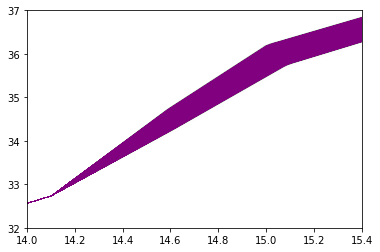

In [52]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):

    g0 = float(predictions[i][0])
    g1 = float(predictions[i][1])
    g2 = float(predictions[i][2])
    p1 = float(predictions[i][3])
    p2 = float(predictions[i][4])
    
    if i%10==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
    eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.005)
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Actual Values EOS

In [73]:
gamma0 = np.loadtxt("eos_polytrope_gamma_0-50000.dat.txt", dtype=float)
gamma1 = np.loadtxt("eos_polytrope_gamma_1-50000.dat.txt", dtype=float)
gamma2 = np.loadtxt("eos_polytrope_gamma_2-50000.dat.txt", dtype=float)
l1 = np.loadtxt('lambda_1-50000.dat.txt', dtype=float)
l2 = np.loadtxt('lambda_2-50000.dat.txt', dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1-50000.dat.txt", dtype=float)
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2-50000.dat.txt", dtype=float)
m1 = np.loadtxt("mass_1_source-50000.dat.txt", dtype=float)
m2 = np.loadtxt("mass_2_source-50000.dat.txt", dtype=float)

logp1_s = logp1_cgs - 1
logp2_s = logp2_cgs - 1

length = len(gamma0)

In [75]:
length

50000

Progress : 0 / 50000, 0.00%
Progress : 10 / 50000, 0.02%
Progress : 20 / 50000, 0.04%
Progress : 30 / 50000, 0.06%
Progress : 40 / 50000, 0.08%
Progress : 50 / 50000, 0.10%
Progress : 60 / 50000, 0.12%
Progress : 70 / 50000, 0.14%
Progress : 80 / 50000, 0.16%
Progress : 90 / 50000, 0.18%
Progress : 100 / 50000, 0.20%
Progress : 110 / 50000, 0.22%
Progress : 120 / 50000, 0.24%
Progress : 130 / 50000, 0.26%
Progress : 140 / 50000, 0.28%
Progress : 150 / 50000, 0.30%
Progress : 160 / 50000, 0.32%
Progress : 170 / 50000, 0.34%
Progress : 180 / 50000, 0.36%
Progress : 190 / 50000, 0.38%
Progress : 200 / 50000, 0.40%
Progress : 210 / 50000, 0.42%
Progress : 220 / 50000, 0.44%
Progress : 230 / 50000, 0.46%
Progress : 240 / 50000, 0.48%
Progress : 250 / 50000, 0.50%
Progress : 260 / 50000, 0.52%
Progress : 270 / 50000, 0.54%
Progress : 280 / 50000, 0.56%
Progress : 290 / 50000, 0.58%
Progress : 300 / 50000, 0.60%
Progress : 310 / 50000, 0.62%
Progress : 320 / 50000, 0.64%
Progress : 330 / 5000

GSL function failed: interpolation error (errnum=1)
XLAL Error - <GSL function> (interp.c:150): Generic failure


RuntimeError: Generic failure

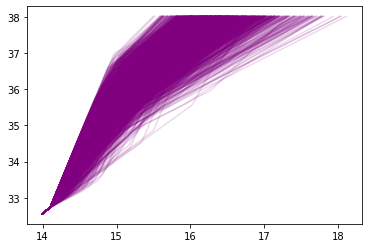

In [76]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):
    
    try:
        g0 = float(gamma0[i])
        g1 = float(gamma1[i])
        g2 = float(gamma2[i])
        p1 = float(logp1_s[i])
        p2 = float(logp2_s[i])

        if i%10==0:
            print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
        pdat = []
        rdat = []
        #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
        eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
        hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
        hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
        hdat = np.concatenate([hlow,hhigh])
        for h in hdat:
            pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
            rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
        #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
        plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.15)
    
    except:
        print("failed!")

plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Loss

In [ ]:
history.history.keys() 

In [ ]:
#loss for gamma0 values
loss_train = history.history['gamma0_output_loss']
loss_val = history.history['val_gamma0_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma1 values
loss_train = history.history['gamma1_output_loss']
loss_val = history.history['val_gamma1_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma2 values
loss_train = history.history['gamma2_output_loss']
loss_val = history.history['val_gamma2_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for logp1_si values
loss_train = history.history['logp1_si_output_loss']
loss_val = history.history['val_logp1_si_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp1_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#loss for logp2_si values
loss_train = history.history['logp2_si_output_loss']
loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp2_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()